In [15]:
import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 

In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results







In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [75]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [76]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [77]:
configs.specifier = specifier
configs.data_name = data_name



In [78]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

# demo-Fcls-mm:

- Chosen model: **MLP**



https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

## Load Data

In [8]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)




In [9]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 


In [11]:

df_data_to_use.head()



,Group,SubjectID,Sex,Grade,Age,IQ,Reading_speed
0,1,10,1,4,10,23,102.0
1,1,108,1,4,10,34,139.0
2,1,11,2,4,10,34,110.0
3,1,11_norm1,1,2,9,28,71.0
4,1,12_norm1,2,2,8,32,60.0


In [17]:
normals = pd.concat([df_data_to_use.loc[df_data_to_use.Group == 1]]*650)
normals

,Group,SubjectID,Sex,Grade,Age,IQ,Reading_speed
0,1,10,1,4,10,23,102.0
1,1,108,1,4,10,34,139.0
2,1,11,2,4,10,34,110.0
3,1,11_norm1,1,2,9,28,71.0
4,1,12_norm1,2,2,8,32,60.0
...,...,...,...,...,...,...,...
208,1,s94,1,4,10,36,154.0
209,1,s95,2,5,12,35,156.0
210,1,s96,2,5,11,32,121.0
211,1,s97,2,4,11,30,133.0


In [19]:
dyslexics = pd.concat([df_data_to_use.loc[df_data_to_use.Group == 3]]*830)
dyslexics

,Group,SubjectID,Sex,Grade,Age,IQ,Reading_speed
0,3,ake05,1,3,9,35,38.0
1,3,asd17,2,4,10,34,57.0
2,3,bai24,2,1,7,28,6.0
3,3,eki26,1,1,8,35,6.0
4,3,fka11,2,2,9,32,48.0
...,...,...,...,...,...,...,...
67,3,tka06,1,4,11,35,96.0
68,3,vpa21,2,1,7,32,22.0
69,3,yea20,1,3,9,34,20.0
70,3,zaa15,1,3,10,31,78.0


In [20]:
26073/22

1185.1363636363637

In [21]:
at_risk = pd.concat([df_data_to_use.loc[df_data_to_use.Group == 2]]*1185)
at_risk

,Group,SubjectID,Sex,Grade,Age,IQ,Reading_speed
0,2,m107,1,2,9,36,50.0
1,2,m108,2,4,10,34,85.0
2,2,m25,1,6,12,36,85.0
3,2,m29,2,6,12,34,95.0
4,2,m46,2,4,10,35,82.0
...,...,...,...,...,...,...,...
17,2,s25,1,1,7,30,25.0
18,2,s26,2,2,8,31,50.0
19,2,s29,2,1,6,27,29.0
20,2,s58,1,1,8,32,26.0


In [23]:
df_data_to_use = pd.concat([normals, dyslexics, at_risk])
df_data_to_use

,Group,SubjectID,Sex,Grade,Age,IQ,Reading_speed
0,1,10,1,4,10,23,102.0
1,1,108,1,4,10,34,139.0
2,1,11,2,4,10,34,110.0
3,1,11_norm1,1,2,9,28,71.0
4,1,12_norm1,2,2,8,32,60.0
...,...,...,...,...,...,...,...
17,2,s25,1,1,7,30,25.0
18,2,s26,2,2,8,31,50.0
19,2,s29,2,1,6,27,29.0
20,2,s58,1,1,8,32,26.0


In [24]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [25]:

x_org.head()



,Grade_1,Age,Grade_4,Grade_6,Grade_3,Sex_2,Grade_2,Grade_5,Sex_1,IQ
0,0,10,1,0,0,0,0,0,1,23
1,0,10,1,0,0,0,0,0,1,34
2,0,10,1,0,0,1,0,0,0,34
3,0,9,0,0,0,0,1,0,1,28
4,0,8,0,0,0,1,1,0,0,32


In [26]:
# for i in range(x_org.Sex_1.values.shape[0]):
#     print(x_org.Sex_1.values[i], x_org.Sex_2.values[i])

In [27]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,139.0
2,1,110.0
3,1,71.0
4,1,60.0


In [79]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [29]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (224280, 10)


In [30]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [31]:

data



defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.   , 0.5  , 1.   , ..., 0.   , 1.   , 0.381],
                                 [0.   , 0.5  , 1.   , ..., 0.   , 1.   , 0.905],
                                 [0.   , 0.5  , 1.   , ..., 0.   , 0.   , 0.905],
                                 ...,
                                 [1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.571],
                                 [1.   , 0.25 , 0.   , ..., 0.   , 1.   , 0.81 ],
                                 [0.   , 0.625, 0.   , ..., 1.   , 0.   , 0.762]]),
                          'x_test': array([[0.   , 0.25 , 0.   , ..., 0.   , 1.   , 0.762],
                                 [0.   , 0.5  , 1.   , ..., 0.   , 0.   , 1.   ],
                                 [0.   , 0.375, 0.   , ..., 0.   , 1.   , 0.952],
                                 ...,
                                 [0.   , 0.75 , 0.   , ..., 0.   , 1.   , 1.   ],
        

## Load the tuned parameters

In [80]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [81]:
# OrderedDict([('activation', 'identity'),
#              ('hidden_layer_sizes', 173),
#              ('max_iter', 31270),
#              ('solver', 'lbfgs')])



In [83]:
specifier

'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

In [ ]:
# save_a_dict(a_dict=tuned_params,
#             name='dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0',
#             save_path=configs.params_path,
#            )

In [84]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl


MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [85]:
x_train = data["4"]["x_train"]
x_test = data["4"]["x_test"]
y_train = data["4"]["y_train"]
y_test = data["4"]["y_test"]



In [86]:

class_names = ['Norm', 'At-risk', 'Dyslexic']




In [87]:
# from joblib import dump, load


# mdl = load(configs.models_path.joinpath(configs.specifier+".joblib"))
# mdl


In [88]:

# results = load_a_dict(
#     name=configs.specifier,
#     save_path=configs.results_path,
#         )




# for i in range(1, 11):
#     i = str(i)
#     y_test_ = results[i]["y_test"]
#     y_pred_ = results[i]["y_pred"]
#     y_prob_ = results[i]["y_pred_prob"]
    
#     cm = sklearn.metrics.confusion_matrix(
#     y_true=y_test_, 
#     y_pred=y_pred_
#     )
    
#     disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=class_names
#                              )
#     disp.plot()
#     plt.show()
    
    
#     print(
#         "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
#         "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
#                                                   multi_class="ovr",
#                                                   average="weighted")
#     )





In [89]:


# print_the_evaluated_results(
#     results=results, 
#     learning_method=learning_method
# )



In [90]:
y_train.shape, x_test.shape

((201852,), (22428, 10))

In [ ]:


mdl.fit(x_train, y_train)




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2215     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17713D+00    |proj g|=  3.46992D-01


 This problem is unconstrained.



At iterate    1    f=  8.95279D-01    |proj g|=  3.14910D-02

At iterate    2    f=  8.85813D-01    |proj g|=  1.33284D-02

At iterate    3    f=  8.64442D-01    |proj g|=  2.10087D-02

At iterate    4    f=  8.49910D-01    |proj g|=  2.28604D-02

At iterate    5    f=  8.30603D-01    |proj g|=  5.89811D-03

At iterate    6    f=  8.23240D-01    |proj g|=  1.26928D-02

At iterate    7    f=  8.18442D-01    |proj g|=  1.16687D-02

At iterate    8    f=  8.13616D-01    |proj g|=  4.46826D-03

At iterate    9    f=  8.12524D-01    |proj g|=  3.19328D-03

At iterate   10    f=  8.12105D-01    |proj g|=  1.89086D-03

At iterate   11    f=  8.10881D-01    |proj g|=  3.46628D-03

At iterate   12    f=  8.10211D-01    |proj g|=  1.52142D-03

At iterate   13    f=  8.09992D-01    |proj g|=  6.74541D-03

At iterate   14    f=  8.09684D-01    |proj g|=  2.11983D-03

At iterate   15    f=  8.09567D-01    |proj g|=  1.41504D-03

At iterate   16    f=  8.09168D-01    |proj g|=  9.85812D-04

At iter


At iterate  134    f=  7.17367D-01    |proj g|=  7.73396D-03

At iterate  135    f=  7.17145D-01    |proj g|=  7.13398D-03

At iterate  136    f=  7.16367D-01    |proj g|=  8.13056D-03

At iterate  137    f=  7.15591D-01    |proj g|=  7.16297D-03

At iterate  138    f=  7.15153D-01    |proj g|=  9.56680D-03

At iterate  139    f=  7.14391D-01    |proj g|=  4.89123D-03

At iterate  140    f=  7.13954D-01    |proj g|=  6.67094D-03

At iterate  141    f=  7.13557D-01    |proj g|=  8.59010D-03

At iterate  142    f=  7.13064D-01    |proj g|=  1.36597D-02

At iterate  143    f=  7.12383D-01    |proj g|=  9.15181D-03

At iterate  144    f=  7.11609D-01    |proj g|=  6.83623D-03

At iterate  145    f=  7.11361D-01    |proj g|=  1.27227D-02

At iterate  146    f=  7.10901D-01    |proj g|=  9.19317D-03

At iterate  147    f=  7.10221D-01    |proj g|=  7.97070D-03

At iterate  148    f=  7.08693D-01    |proj g|=  8.27806D-03

At iterate  149    f=  7.07726D-01    |proj g|=  7.14372D-03

At iter


At iterate  267    f=  6.44726D-01    |proj g|=  8.22308D-03

At iterate  268    f=  6.44541D-01    |proj g|=  5.33019D-03

At iterate  269    f=  6.44378D-01    |proj g|=  8.60044D-03

At iterate  270    f=  6.44170D-01    |proj g|=  5.21276D-03

At iterate  271    f=  6.43927D-01    |proj g|=  8.48533D-03

At iterate  272    f=  6.43682D-01    |proj g|=  1.11207D-02

At iterate  273    f=  6.43311D-01    |proj g|=  1.08970D-02

At iterate  274    f=  6.42818D-01    |proj g|=  7.78668D-03

At iterate  275    f=  6.42714D-01    |proj g|=  8.24106D-03

At iterate  276    f=  6.42413D-01    |proj g|=  4.46458D-03

At iterate  277    f=  6.42243D-01    |proj g|=  6.28655D-03

At iterate  278    f=  6.41964D-01    |proj g|=  9.10806D-03

At iterate  279    f=  6.41585D-01    |proj g|=  1.03405D-02

At iterate  280    f=  6.41423D-01    |proj g|=  1.23542D-02

At iterate  281    f=  6.41029D-01    |proj g|=  1.00133D-02

At iterate  282    f=  6.40769D-01    |proj g|=  8.53495D-03

At iter


At iterate  400    f=  5.94503D-01    |proj g|=  1.23519D-02

At iterate  401    f=  5.93628D-01    |proj g|=  8.70832D-03

At iterate  402    f=  5.93319D-01    |proj g|=  7.37333D-03

At iterate  403    f=  5.92521D-01    |proj g|=  8.26839D-03

At iterate  404    f=  5.92124D-01    |proj g|=  1.51691D-02

At iterate  405    f=  5.91425D-01    |proj g|=  1.12225D-02

At iterate  406    f=  5.90756D-01    |proj g|=  8.47301D-03

At iterate  407    f=  5.90262D-01    |proj g|=  1.23813D-02

At iterate  408    f=  5.89823D-01    |proj g|=  8.58545D-03

At iterate  409    f=  5.89365D-01    |proj g|=  6.22650D-03

At iterate  410    f=  5.89069D-01    |proj g|=  5.94396D-03

At iterate  411    f=  5.88445D-01    |proj g|=  7.80605D-03

At iterate  412    f=  5.87875D-01    |proj g|=  1.17929D-02

At iterate  413    f=  5.87054D-01    |proj g|=  8.05802D-03

At iterate  414    f=  5.86518D-01    |proj g|=  5.19254D-03

At iterate  415    f=  5.85859D-01    |proj g|=  7.03538D-03

At iter


At iterate  533    f=  5.09917D-01    |proj g|=  1.03671D-02

At iterate  534    f=  5.08960D-01    |proj g|=  9.99829D-03

At iterate  535    f=  5.08425D-01    |proj g|=  1.27293D-02

At iterate  536    f=  5.07536D-01    |proj g|=  9.24757D-03

At iterate  537    f=  5.07098D-01    |proj g|=  7.31957D-03

At iterate  538    f=  5.06596D-01    |proj g|=  7.34653D-03

At iterate  539    f=  5.06305D-01    |proj g|=  1.37045D-02

At iterate  540    f=  5.05827D-01    |proj g|=  6.90698D-03

At iterate  541    f=  5.05332D-01    |proj g|=  5.39149D-03

At iterate  542    f=  5.05041D-01    |proj g|=  1.61380D-02

At iterate  543    f=  5.04614D-01    |proj g|=  1.02164D-02

At iterate  544    f=  5.04349D-01    |proj g|=  1.19851D-02

At iterate  545    f=  5.03693D-01    |proj g|=  1.19931D-02

At iterate  546    f=  5.02929D-01    |proj g|=  1.03598D-02

At iterate  547    f=  5.02514D-01    |proj g|=  1.20036D-02

At iterate  548    f=  5.01797D-01    |proj g|=  5.70830D-03

At iter


At iterate  666    f=  4.23906D-01    |proj g|=  1.46678D-02

At iterate  667    f=  4.22704D-01    |proj g|=  1.40624D-02

At iterate  668    f=  4.22353D-01    |proj g|=  1.71782D-02

At iterate  669    f=  4.21884D-01    |proj g|=  1.11937D-02

At iterate  670    f=  4.21103D-01    |proj g|=  1.20950D-02

At iterate  671    f=  4.20086D-01    |proj g|=  1.73015D-02

At iterate  672    f=  4.18761D-01    |proj g|=  2.65173D-02

At iterate  673    f=  4.18332D-01    |proj g|=  1.92986D-02

At iterate  674    f=  4.17657D-01    |proj g|=  1.05452D-02

At iterate  675    f=  4.17220D-01    |proj g|=  7.89301D-03

At iterate  676    f=  4.16675D-01    |proj g|=  1.05858D-02

At iterate  677    f=  4.16177D-01    |proj g|=  6.22851D-03

At iterate  678    f=  4.16091D-01    |proj g|=  2.61448D-02

At iterate  679    f=  4.15650D-01    |proj g|=  6.06721D-03

At iterate  680    f=  4.15458D-01    |proj g|=  8.84671D-03

At iterate  681    f=  4.15140D-01    |proj g|=  1.17635D-02

At iter


At iterate  799    f=  3.56993D-01    |proj g|=  9.39759D-03

At iterate  800    f=  3.56766D-01    |proj g|=  1.64969D-02

At iterate  801    f=  3.56561D-01    |proj g|=  9.79649D-03

At iterate  802    f=  3.56466D-01    |proj g|=  5.10049D-03

At iterate  803    f=  3.56204D-01    |proj g|=  5.26336D-03

At iterate  804    f=  3.55930D-01    |proj g|=  1.09107D-02

At iterate  805    f=  3.55582D-01    |proj g|=  1.46067D-02

At iterate  806    f=  3.55219D-01    |proj g|=  8.97310D-03

At iterate  807    f=  3.54852D-01    |proj g|=  1.04403D-02

At iterate  808    f=  3.54738D-01    |proj g|=  4.06090D-02

At iterate  809    f=  3.54435D-01    |proj g|=  8.07495D-03

At iterate  810    f=  3.54354D-01    |proj g|=  8.33107D-03

At iterate  811    f=  3.54118D-01    |proj g|=  5.21513D-03

At iterate  812    f=  3.53985D-01    |proj g|=  2.22185D-02

At iterate  813    f=  3.53735D-01    |proj g|=  6.66826D-03

At iterate  814    f=  3.53626D-01    |proj g|=  7.38068D-03

At iter


At iterate  932    f=  3.36972D-01    |proj g|=  3.78486D-03

At iterate  933    f=  3.36904D-01    |proj g|=  5.34356D-03

At iterate  934    f=  3.36826D-01    |proj g|=  5.37919D-03

At iterate  935    f=  3.36768D-01    |proj g|=  1.05698D-02

At iterate  936    f=  3.36675D-01    |proj g|=  4.44429D-03

At iterate  937    f=  3.36612D-01    |proj g|=  5.28829D-03

At iterate  938    f=  3.36547D-01    |proj g|=  4.93108D-03

At iterate  939    f=  3.36442D-01    |proj g|=  5.57050D-03

At iterate  940    f=  3.36323D-01    |proj g|=  1.11847D-02

At iterate  941    f=  3.36158D-01    |proj g|=  5.42476D-03

At iterate  942    f=  3.36040D-01    |proj g|=  5.56592D-03

At iterate  943    f=  3.35864D-01    |proj g|=  7.93582D-03

At iterate  944    f=  3.35780D-01    |proj g|=  8.58902D-03

At iterate  945    f=  3.35694D-01    |proj g|=  5.81670D-03

At iterate  946    f=  3.35612D-01    |proj g|=  1.14533D-02

At iterate  947    f=  3.35549D-01    |proj g|=  5.46089D-03

At iter


At iterate 1065    f=  3.24863D-01    |proj g|=  9.09060D-03

At iterate 1066    f=  3.24829D-01    |proj g|=  4.18806D-03

At iterate 1067    f=  3.24793D-01    |proj g|=  5.14877D-03

At iterate 1068    f=  3.24732D-01    |proj g|=  6.82198D-03

At iterate 1069    f=  3.24698D-01    |proj g|=  1.52099D-02

At iterate 1070    f=  3.24634D-01    |proj g|=  4.54665D-03

At iterate 1071    f=  3.24595D-01    |proj g|=  3.88487D-03

At iterate 1072    f=  3.24559D-01    |proj g|=  4.13064D-03

At iterate 1073    f=  3.24498D-01    |proj g|=  5.74816D-03

At iterate 1074    f=  3.24459D-01    |proj g|=  6.52352D-03

At iterate 1075    f=  3.24399D-01    |proj g|=  3.36863D-03

At iterate 1076    f=  3.24363D-01    |proj g|=  3.30949D-03

At iterate 1077    f=  3.24319D-01    |proj g|=  7.87508D-03

At iterate 1078    f=  3.24297D-01    |proj g|=  9.86848D-03

At iterate 1079    f=  3.24261D-01    |proj g|=  4.04624D-03

At iterate 1080    f=  3.24228D-01    |proj g|=  4.10868D-03

At iter


At iterate 1198    f=  3.20410D-01    |proj g|=  1.99774D-03

At iterate 1199    f=  3.20399D-01    |proj g|=  2.15299D-03

At iterate 1200    f=  3.20385D-01    |proj g|=  2.47827D-03

At iterate 1201    f=  3.20358D-01    |proj g|=  3.76093D-03

At iterate 1202    f=  3.20334D-01    |proj g|=  6.47160D-03

At iterate 1203    f=  3.20312D-01    |proj g|=  2.10894D-03

At iterate 1204    f=  3.20287D-01    |proj g|=  3.32151D-03

At iterate 1205    f=  3.20265D-01    |proj g|=  3.44474D-03

At iterate 1206    f=  3.20214D-01    |proj g|=  5.14926D-03

At iterate 1207    f=  3.20192D-01    |proj g|=  1.06296D-02

At iterate 1208    f=  3.20151D-01    |proj g|=  4.06096D-03

At iterate 1209    f=  3.20135D-01    |proj g|=  2.70843D-03

At iterate 1210    f=  3.20115D-01    |proj g|=  3.53715D-03

At iterate 1211    f=  3.20083D-01    |proj g|=  5.68896D-03

At iterate 1212    f=  3.20053D-01    |proj g|=  4.58244D-03

At iterate 1213    f=  3.20032D-01    |proj g|=  2.32238D-03

At iter


At iterate 1331    f=  3.16520D-01    |proj g|=  4.03170D-03

At iterate 1332    f=  3.16510D-01    |proj g|=  6.18782D-03

At iterate 1333    f=  3.16493D-01    |proj g|=  3.79388D-03

At iterate 1334    f=  3.16469D-01    |proj g|=  2.49753D-03

At iterate 1335    f=  3.16456D-01    |proj g|=  3.04852D-03

At iterate 1336    f=  3.16426D-01    |proj g|=  6.73853D-03

At iterate 1337    f=  3.16404D-01    |proj g|=  5.46019D-03

At iterate 1338    f=  3.16373D-01    |proj g|=  2.91388D-03

At iterate 1339    f=  3.16352D-01    |proj g|=  2.85084D-03

At iterate 1340    f=  3.16327D-01    |proj g|=  3.17804D-03

At iterate 1341    f=  3.16306D-01    |proj g|=  5.01192D-03

At iterate 1342    f=  3.16286D-01    |proj g|=  2.77003D-03

At iterate 1343    f=  3.16274D-01    |proj g|=  1.54428D-03

At iterate 1344    f=  3.16264D-01    |proj g|=  2.00335D-03

At iterate 1345    f=  3.16254D-01    |proj g|=  3.28744D-03

At iterate 1346    f=  3.16240D-01    |proj g|=  2.16024D-03

At iter


At iterate 1464    f=  3.13086D-01    |proj g|=  5.43722D-03

At iterate 1465    f=  3.13074D-01    |proj g|=  6.83218D-03

At iterate 1466    f=  3.13058D-01    |proj g|=  3.95639D-03

At iterate 1467    f=  3.13043D-01    |proj g|=  2.21214D-03

At iterate 1468    f=  3.13030D-01    |proj g|=  3.54340D-03

At iterate 1469    f=  3.13015D-01    |proj g|=  3.40910D-03

At iterate 1470    f=  3.12999D-01    |proj g|=  1.70592D-02

At iterate 1471    f=  3.12964D-01    |proj g|=  6.76616D-03

At iterate 1472    f=  3.12932D-01    |proj g|=  2.73832D-03

At iterate 1473    f=  3.12902D-01    |proj g|=  7.36908D-03

At iterate 1474    f=  3.12869D-01    |proj g|=  7.04393D-03

At iterate 1475    f=  3.12848D-01    |proj g|=  6.66491D-03

At iterate 1476    f=  3.12815D-01    |proj g|=  7.18723D-03

At iterate 1477    f=  3.12789D-01    |proj g|=  9.76639D-03

At iterate 1478    f=  3.12762D-01    |proj g|=  5.55178D-03

At iterate 1479    f=  3.12746D-01    |proj g|=  2.55311D-03

At iter


At iterate 1597    f=  3.10013D-01    |proj g|=  1.94976D-03

At iterate 1598    f=  3.10000D-01    |proj g|=  8.02465D-03

At iterate 1599    f=  3.09986D-01    |proj g|=  2.74968D-03

At iterate 1600    f=  3.09976D-01    |proj g|=  1.72856D-03

At iterate 1601    f=  3.09959D-01    |proj g|=  1.86741D-03

At iterate 1602    f=  3.09952D-01    |proj g|=  4.46001D-03

At iterate 1603    f=  3.09943D-01    |proj g|=  1.49285D-03

At iterate 1604    f=  3.09937D-01    |proj g|=  1.41142D-03

At iterate 1605    f=  3.09930D-01    |proj g|=  1.28906D-03

At iterate 1606    f=  3.09919D-01    |proj g|=  2.65395D-03

At iterate 1607    f=  3.09914D-01    |proj g|=  5.04011D-03

At iterate 1608    f=  3.09902D-01    |proj g|=  2.87580D-03

At iterate 1609    f=  3.09895D-01    |proj g|=  1.59178D-03

At iterate 1610    f=  3.09891D-01    |proj g|=  1.76028D-03

At iterate 1611    f=  3.09880D-01    |proj g|=  2.50976D-03

At iterate 1612    f=  3.09872D-01    |proj g|=  5.14415D-03

At iter


At iterate 1730    f=  3.08109D-01    |proj g|=  4.79411D-03

At iterate 1731    f=  3.08067D-01    |proj g|=  3.32387D-03

At iterate 1732    f=  3.08021D-01    |proj g|=  3.28750D-03

At iterate 1733    f=  3.07961D-01    |proj g|=  4.19787D-03

At iterate 1734    f=  3.07924D-01    |proj g|=  5.71584D-03

At iterate 1735    f=  3.07873D-01    |proj g|=  4.73795D-03

At iterate 1736    f=  3.07843D-01    |proj g|=  6.74145D-03

At iterate 1737    f=  3.07807D-01    |proj g|=  2.11519D-03

At iterate 1738    f=  3.07784D-01    |proj g|=  2.17674D-03

At iterate 1739    f=  3.07730D-01    |proj g|=  7.43971D-03

At iterate 1740    f=  3.07705D-01    |proj g|=  3.37952D-03

At iterate 1741    f=  3.07684D-01    |proj g|=  3.00423D-03

At iterate 1742    f=  3.07646D-01    |proj g|=  2.43256D-03

At iterate 1743    f=  3.07633D-01    |proj g|=  7.14049D-03

At iterate 1744    f=  3.07618D-01    |proj g|=  4.13857D-03

At iterate 1745    f=  3.07609D-01    |proj g|=  2.77246D-03

At iter


At iterate 1863    f=  3.04527D-01    |proj g|=  1.03431D-02

At iterate 1864    f=  3.04469D-01    |proj g|=  1.28909D-02

At iterate 1865    f=  3.04430D-01    |proj g|=  2.42960D-03

At iterate 1866    f=  3.04403D-01    |proj g|=  4.28872D-03

At iterate 1867    f=  3.04381D-01    |proj g|=  5.36595D-03

At iterate 1868    f=  3.04326D-01    |proj g|=  6.84867D-03

At iterate 1869    f=  3.04307D-01    |proj g|=  3.94471D-03

At iterate 1870    f=  3.04285D-01    |proj g|=  2.34997D-03

At iterate 1871    f=  3.04265D-01    |proj g|=  5.04320D-03

At iterate 1872    f=  3.04248D-01    |proj g|=  4.59152D-03

At iterate 1873    f=  3.04230D-01    |proj g|=  3.20757D-03

At iterate 1874    f=  3.04202D-01    |proj g|=  2.37953D-03

At iterate 1875    f=  3.04179D-01    |proj g|=  2.71956D-03

At iterate 1876    f=  3.04147D-01    |proj g|=  1.05878D-02

At iterate 1877    f=  3.04111D-01    |proj g|=  4.11453D-03

At iterate 1878    f=  3.04082D-01    |proj g|=  3.24370D-03

At iter


At iterate 1996    f=  3.01894D-01    |proj g|=  3.53721D-03

At iterate 1997    f=  3.01883D-01    |proj g|=  5.00355D-03

At iterate 1998    f=  3.01870D-01    |proj g|=  2.94798D-03

At iterate 1999    f=  3.01852D-01    |proj g|=  2.29183D-03

At iterate 2000    f=  3.01835D-01    |proj g|=  2.44538D-03

At iterate 2001    f=  3.01819D-01    |proj g|=  7.61836D-03

At iterate 2002    f=  3.01791D-01    |proj g|=  2.49168D-03

At iterate 2003    f=  3.01777D-01    |proj g|=  2.60408D-03

At iterate 2004    f=  3.01764D-01    |proj g|=  3.00406D-03

At iterate 2005    f=  3.01753D-01    |proj g|=  4.09783D-03

At iterate 2006    f=  3.01740D-01    |proj g|=  2.39072D-03

At iterate 2007    f=  3.01727D-01    |proj g|=  1.65677D-03

At iterate 2008    f=  3.01715D-01    |proj g|=  2.68101D-03

At iterate 2009    f=  3.01698D-01    |proj g|=  4.86342D-03

At iterate 2010    f=  3.01680D-01    |proj g|=  4.38567D-03

At iterate 2011    f=  3.01664D-01    |proj g|=  2.40877D-03

At iter


At iterate 2129    f=  3.00104D-01    |proj g|=  9.90159D-03

At iterate 2130    f=  3.00079D-01    |proj g|=  4.28093D-03

At iterate 2131    f=  3.00067D-01    |proj g|=  2.55562D-03

At iterate 2132    f=  3.00060D-01    |proj g|=  2.65326D-03

At iterate 2133    f=  3.00043D-01    |proj g|=  2.55443D-03

At iterate 2134    f=  3.00034D-01    |proj g|=  1.08315D-02

At iterate 2135    f=  3.00012D-01    |proj g|=  3.00665D-03

At iterate 2136    f=  2.99999D-01    |proj g|=  2.12071D-03

At iterate 2137    f=  2.99989D-01    |proj g|=  2.29282D-03

At iterate 2138    f=  2.99969D-01    |proj g|=  2.78162D-03

At iterate 2139    f=  2.99955D-01    |proj g|=  2.62258D-03

At iterate 2140    f=  2.99944D-01    |proj g|=  4.70572D-03

At iterate 2141    f=  2.99937D-01    |proj g|=  1.83931D-03

At iterate 2142    f=  2.99930D-01    |proj g|=  1.79897D-03

At iterate 2143    f=  2.99922D-01    |proj g|=  4.27777D-03

At iterate 2144    f=  2.99911D-01    |proj g|=  3.39437D-03

At iter


At iterate 2262    f=  2.99118D-01    |proj g|=  1.22209D-03

At iterate 2263    f=  2.99115D-01    |proj g|=  1.73475D-03

At iterate 2264    f=  2.99111D-01    |proj g|=  1.83599D-03

At iterate 2265    f=  2.99105D-01    |proj g|=  1.66749D-03

At iterate 2266    f=  2.99101D-01    |proj g|=  3.75103D-03

At iterate 2267    f=  2.99092D-01    |proj g|=  1.35946D-03

At iterate 2268    f=  2.99090D-01    |proj g|=  8.18002D-04

At iterate 2269    f=  2.99087D-01    |proj g|=  9.37764D-04

At iterate 2270    f=  2.99083D-01    |proj g|=  1.75753D-03

At iterate 2271    f=  2.99080D-01    |proj g|=  2.16745D-03

At iterate 2272    f=  2.99074D-01    |proj g|=  1.35759D-03

At iterate 2273    f=  2.99072D-01    |proj g|=  1.07204D-03

At iterate 2274    f=  2.99067D-01    |proj g|=  1.77268D-03

At iterate 2275    f=  2.99061D-01    |proj g|=  2.05920D-03

At iterate 2276    f=  2.99055D-01    |proj g|=  1.17971D-03

At iterate 2277    f=  2.99050D-01    |proj g|=  1.59184D-03

At iter


At iterate 2395    f=  2.98814D-01    |proj g|=  1.05914D-03

At iterate 2396    f=  2.98811D-01    |proj g|=  8.37761D-04

At iterate 2397    f=  2.98808D-01    |proj g|=  1.52906D-03

At iterate 2398    f=  2.98806D-01    |proj g|=  1.02127D-03

At iterate 2399    f=  2.98805D-01    |proj g|=  7.90636D-04

At iterate 2400    f=  2.98804D-01    |proj g|=  7.60048D-04

At iterate 2401    f=  2.98802D-01    |proj g|=  9.43875D-04

At iterate 2402    f=  2.98800D-01    |proj g|=  2.35417D-03

At iterate 2403    f=  2.98798D-01    |proj g|=  8.30728D-04

At iterate 2404    f=  2.98797D-01    |proj g|=  7.08860D-04

At iterate 2405    f=  2.98795D-01    |proj g|=  9.13799D-04

At iterate 2406    f=  2.98794D-01    |proj g|=  2.21713D-03

At iterate 2407    f=  2.98792D-01    |proj g|=  9.09832D-04

At iterate 2408    f=  2.98790D-01    |proj g|=  1.11525D-03

At iterate 2409    f=  2.98788D-01    |proj g|=  1.49237D-03

At iterate 2410    f=  2.98787D-01    |proj g|=  1.51228D-03

At iter


At iterate 2528    f=  2.98572D-01    |proj g|=  8.50832D-04

At iterate 2529    f=  2.98571D-01    |proj g|=  9.74097D-04

At iterate 2530    f=  2.98568D-01    |proj g|=  1.95284D-03

At iterate 2531    f=  2.98566D-01    |proj g|=  1.62293D-03

At iterate 2532    f=  2.98563D-01    |proj g|=  1.54945D-03

At iterate 2533    f=  2.98560D-01    |proj g|=  1.03512D-03

At iterate 2534    f=  2.98557D-01    |proj g|=  1.43056D-03

At iterate 2535    f=  2.98554D-01    |proj g|=  4.02363D-03

At iterate 2536    f=  2.98550D-01    |proj g|=  1.75219D-03

At iterate 2537    f=  2.98545D-01    |proj g|=  1.52476D-03

At iterate 2538    f=  2.98542D-01    |proj g|=  1.51381D-03

At iterate 2539    f=  2.98539D-01    |proj g|=  4.72953D-03

At iterate 2540    f=  2.98535D-01    |proj g|=  1.36373D-03

At iterate 2541    f=  2.98532D-01    |proj g|=  9.53323D-04

At iterate 2542    f=  2.98529D-01    |proj g|=  1.11042D-03

At iterate 2543    f=  2.98524D-01    |proj g|=  1.77268D-03

At iter


At iterate 2661    f=  2.98273D-01    |proj g|=  2.43856D-03

At iterate 2662    f=  2.98271D-01    |proj g|=  1.84408D-03

At iterate 2663    f=  2.98268D-01    |proj g|=  9.55591D-04

At iterate 2664    f=  2.98265D-01    |proj g|=  9.74996D-04

At iterate 2665    f=  2.98260D-01    |proj g|=  2.53794D-03

At iterate 2666    f=  2.98256D-01    |proj g|=  2.23305D-03

At iterate 2667    f=  2.98253D-01    |proj g|=  1.29794D-03

At iterate 2668    f=  2.98249D-01    |proj g|=  1.13681D-03

At iterate 2669    f=  2.98247D-01    |proj g|=  1.09418D-03

At iterate 2670    f=  2.98243D-01    |proj g|=  1.91961D-03

At iterate 2671    f=  2.98240D-01    |proj g|=  3.63620D-03

At iterate 2672    f=  2.98238D-01    |proj g|=  2.59480D-03

At iterate 2673    f=  2.98236D-01    |proj g|=  1.11671D-03

At iterate 2674    f=  2.98235D-01    |proj g|=  8.29441D-04

At iterate 2675    f=  2.98233D-01    |proj g|=  1.21837D-03

At iterate 2676    f=  2.98229D-01    |proj g|=  1.52399D-03

At iter


At iterate 2794    f=  2.98106D-01    |proj g|=  6.07006D-04

At iterate 2795    f=  2.98105D-01    |proj g|=  3.78077D-04

At iterate 2796    f=  2.98105D-01    |proj g|=  7.62841D-04

At iterate 2797    f=  2.98104D-01    |proj g|=  8.78538D-04

At iterate 2798    f=  2.98103D-01    |proj g|=  5.57683D-04

At iterate 2799    f=  2.98103D-01    |proj g|=  4.31723D-04

At iterate 2800    f=  2.98102D-01    |proj g|=  9.38181D-04

At iterate 2801    f=  2.98099D-01    |proj g|=  7.05946D-04

At iterate 2802    f=  2.98099D-01    |proj g|=  2.20750D-03

At iterate 2803    f=  2.98097D-01    |proj g|=  5.72278D-04

At iterate 2804    f=  2.98096D-01    |proj g|=  5.37169D-04

At iterate 2805    f=  2.98095D-01    |proj g|=  6.23911D-04

At iterate 2806    f=  2.98094D-01    |proj g|=  1.30651D-03

At iterate 2807    f=  2.98093D-01    |proj g|=  6.08279D-04

At iterate 2808    f=  2.98091D-01    |proj g|=  6.73488D-04

At iterate 2809    f=  2.98090D-01    |proj g|=  2.83505D-03

At iter


At iterate 2927    f=  2.97842D-01    |proj g|=  9.83903D-04

At iterate 2928    f=  2.97840D-01    |proj g|=  1.04165D-03

At iterate 2929    f=  2.97835D-01    |proj g|=  1.63619D-03

At iterate 2930    f=  2.97828D-01    |proj g|=  2.43470D-03

At iterate 2931    f=  2.97825D-01    |proj g|=  7.49332D-03

At iterate 2932    f=  2.97815D-01    |proj g|=  1.29703D-03

At iterate 2933    f=  2.97811D-01    |proj g|=  1.29223D-03

At iterate 2934    f=  2.97805D-01    |proj g|=  2.74183D-03

At iterate 2935    f=  2.97797D-01    |proj g|=  3.65547D-03

At iterate 2936    f=  2.97786D-01    |proj g|=  3.50891D-03

At iterate 2937    f=  2.97776D-01    |proj g|=  3.05876D-03

At iterate 2938    f=  2.97771D-01    |proj g|=  1.99495D-03

At iterate 2939    f=  2.97768D-01    |proj g|=  1.16115D-03

At iterate 2940    f=  2.97765D-01    |proj g|=  1.50856D-03

At iterate 2941    f=  2.97760D-01    |proj g|=  2.54379D-03

At iterate 2942    f=  2.97752D-01    |proj g|=  2.37366D-03

At iter


At iterate 3060    f=  2.97383D-01    |proj g|=  3.62898D-03

At iterate 3061    f=  2.97380D-01    |proj g|=  1.31643D-03

At iterate 3062    f=  2.97377D-01    |proj g|=  1.01788D-03

At iterate 3063    f=  2.97375D-01    |proj g|=  1.42910D-03

At iterate 3064    f=  2.97374D-01    |proj g|=  7.41095D-04

At iterate 3065    f=  2.97372D-01    |proj g|=  1.24719D-03

At iterate 3066    f=  2.97370D-01    |proj g|=  1.31719D-03

At iterate 3067    f=  2.97368D-01    |proj g|=  2.04899D-03

At iterate 3068    f=  2.97367D-01    |proj g|=  8.49208D-04

At iterate 3069    f=  2.97366D-01    |proj g|=  5.02721D-04

At iterate 3070    f=  2.97364D-01    |proj g|=  1.42627D-03

At iterate 3071    f=  2.97362D-01    |proj g|=  1.11036D-03

At iterate 3072    f=  2.97360D-01    |proj g|=  2.30099D-03

At iterate 3073    f=  2.97357D-01    |proj g|=  8.52149D-04

At iterate 3074    f=  2.97356D-01    |proj g|=  6.52323D-04

At iterate 3075    f=  2.97355D-01    |proj g|=  6.47594D-04

At iter


At iterate 3193    f=  2.97142D-01    |proj g|=  1.86295D-03

At iterate 3194    f=  2.97141D-01    |proj g|=  1.67480D-03

At iterate 3195    f=  2.97140D-01    |proj g|=  9.78786D-04

At iterate 3196    f=  2.97139D-01    |proj g|=  6.21300D-04

At iterate 3197    f=  2.97137D-01    |proj g|=  9.37871D-04

At iterate 3198    f=  2.97135D-01    |proj g|=  6.41663D-04

At iterate 3199    f=  2.97134D-01    |proj g|=  1.91000D-03

At iterate 3200    f=  2.97133D-01    |proj g|=  5.09622D-04

At iterate 3201    f=  2.97133D-01    |proj g|=  5.32657D-04

At iterate 3202    f=  2.97132D-01    |proj g|=  8.35342D-04

At iterate 3203    f=  2.97131D-01    |proj g|=  1.12112D-03

At iterate 3204    f=  2.97129D-01    |proj g|=  1.77767D-03

At iterate 3205    f=  2.97129D-01    |proj g|=  1.71287D-03

At iterate 3206    f=  2.97128D-01    |proj g|=  7.00161D-04

At iterate 3207    f=  2.97127D-01    |proj g|=  4.90664D-04

At iterate 3208    f=  2.97126D-01    |proj g|=  5.52565D-04

At iter


At iterate 3326    f=  2.96813D-01    |proj g|=  1.28248D-03

At iterate 3327    f=  2.96812D-01    |proj g|=  4.74382D-03

At iterate 3328    f=  2.96806D-01    |proj g|=  1.27013D-03

At iterate 3329    f=  2.96802D-01    |proj g|=  1.20281D-03

At iterate 3330    f=  2.96798D-01    |proj g|=  8.13224D-03

At iterate 3331    f=  2.96792D-01    |proj g|=  3.69623D-03

At iterate 3332    f=  2.96787D-01    |proj g|=  2.31942D-03

At iterate 3333    f=  2.96782D-01    |proj g|=  3.05968D-03

At iterate 3334    f=  2.96775D-01    |proj g|=  2.75865D-03

At iterate 3335    f=  2.96772D-01    |proj g|=  2.31741D-03

At iterate 3336    f=  2.96767D-01    |proj g|=  9.74997D-04

At iterate 3337    f=  2.96764D-01    |proj g|=  8.11933D-04

At iterate 3338    f=  2.96762D-01    |proj g|=  1.01316D-03

At iterate 3339    f=  2.96759D-01    |proj g|=  1.06767D-03

At iterate 3340    f=  2.96756D-01    |proj g|=  2.01494D-03

At iterate 3341    f=  2.96755D-01    |proj g|=  2.47058D-03

At iter


At iterate 3459    f=  2.96383D-01    |proj g|=  1.01577D-03

At iterate 3460    f=  2.96382D-01    |proj g|=  2.60438D-03

At iterate 3461    f=  2.96381D-01    |proj g|=  5.53572D-04

At iterate 3462    f=  2.96381D-01    |proj g|=  6.38373D-04

At iterate 3463    f=  2.96380D-01    |proj g|=  7.38432D-04

At iterate 3464    f=  2.96380D-01    |proj g|=  7.38931D-04

At iterate 3465    f=  2.96378D-01    |proj g|=  1.47460D-03

At iterate 3466    f=  2.96378D-01    |proj g|=  1.68353D-03

At iterate 3467    f=  2.96376D-01    |proj g|=  1.21108D-03

At iterate 3468    f=  2.96375D-01    |proj g|=  6.83380D-04

At iterate 3469    f=  2.96374D-01    |proj g|=  8.86968D-04

At iterate 3470    f=  2.96372D-01    |proj g|=  1.18819D-03

At iterate 3471    f=  2.96369D-01    |proj g|=  1.51958D-03

At iterate 3472    f=  2.96365D-01    |proj g|=  3.28625D-03

At iterate 3473    f=  2.96360D-01    |proj g|=  2.14588D-03

At iterate 3474    f=  2.96356D-01    |proj g|=  1.06344D-03

At iter


At iterate 3592    f=  2.95851D-01    |proj g|=  2.25549D-03

At iterate 3593    f=  2.95848D-01    |proj g|=  1.12828D-03

At iterate 3594    f=  2.95846D-01    |proj g|=  9.46695D-04

At iterate 3595    f=  2.95843D-01    |proj g|=  1.44785D-03

At iterate 3596    f=  2.95838D-01    |proj g|=  1.84351D-03

At iterate 3597    f=  2.95837D-01    |proj g|=  4.11736D-03

At iterate 3598    f=  2.95832D-01    |proj g|=  2.21310D-03

At iterate 3599    f=  2.95827D-01    |proj g|=  8.32415D-04

At iterate 3600    f=  2.95821D-01    |proj g|=  2.77505D-03

At iterate 3601    f=  2.95819D-01    |proj g|=  1.37040D-03

At iterate 3602    f=  2.95817D-01    |proj g|=  8.38821D-04

At iterate 3603    f=  2.95814D-01    |proj g|=  9.18624D-04

At iterate 3604    f=  2.95811D-01    |proj g|=  9.84801D-04

At iterate 3605    f=  2.95807D-01    |proj g|=  2.36695D-03

At iterate 3606    f=  2.95803D-01    |proj g|=  1.60726D-03

At iterate 3607    f=  2.95799D-01    |proj g|=  9.54414D-04

At iter


At iterate 3725    f=  2.95311D-01    |proj g|=  5.35670D-04

At iterate 3726    f=  2.95310D-01    |proj g|=  3.84760D-04

At iterate 3727    f=  2.95310D-01    |proj g|=  1.55958D-03

At iterate 3728    f=  2.95309D-01    |proj g|=  5.12282D-04

At iterate 3729    f=  2.95309D-01    |proj g|=  9.77805D-04

At iterate 3730    f=  2.95308D-01    |proj g|=  1.06387D-03

At iterate 3731    f=  2.95307D-01    |proj g|=  1.90027D-03

At iterate 3732    f=  2.95306D-01    |proj g|=  1.02682D-03

At iterate 3733    f=  2.95306D-01    |proj g|=  4.99765D-04

At iterate 3734    f=  2.95305D-01    |proj g|=  5.58265D-04

At iterate 3735    f=  2.95305D-01    |proj g|=  6.62596D-04

At iterate 3736    f=  2.95304D-01    |proj g|=  5.31067D-04

At iterate 3737    f=  2.95304D-01    |proj g|=  7.32786D-04

At iterate 3738    f=  2.95303D-01    |proj g|=  3.55876D-04

At iterate 3739    f=  2.95303D-01    |proj g|=  3.11606D-04

At iterate 3740    f=  2.95303D-01    |proj g|=  1.47487D-03

At iter


At iterate 3858    f=  2.94867D-01    |proj g|=  1.03359D-03

At iterate 3859    f=  2.94863D-01    |proj g|=  1.74805D-03

At iterate 3860    f=  2.94860D-01    |proj g|=  1.38082D-03

At iterate 3861    f=  2.94857D-01    |proj g|=  3.36495D-03

At iterate 3862    f=  2.94852D-01    |proj g|=  1.50793D-03

At iterate 3863    f=  2.94850D-01    |proj g|=  1.53119D-03

At iterate 3864    f=  2.94842D-01    |proj g|=  2.43185D-03

At iterate 3865    f=  2.94834D-01    |proj g|=  2.36202D-03

At iterate 3866    f=  2.94824D-01    |proj g|=  1.78919D-03

At iterate 3867    f=  2.94807D-01    |proj g|=  1.69330D-03

At iterate 3868    f=  2.94788D-01    |proj g|=  7.29935D-03

At iterate 3869    f=  2.94780D-01    |proj g|=  7.18098D-03

At iterate 3870    f=  2.94768D-01    |proj g|=  1.81321D-03

At iterate 3871    f=  2.94762D-01    |proj g|=  1.81017D-03

At iterate 3872    f=  2.94757D-01    |proj g|=  1.75647D-03

At iterate 3873    f=  2.94746D-01    |proj g|=  1.37268D-03

At iter


At iterate 3991    f=  2.93842D-01    |proj g|=  2.76965D-03

At iterate 3992    f=  2.93834D-01    |proj g|=  2.15367D-03

At iterate 3993    f=  2.93829D-01    |proj g|=  5.71589D-03

At iterate 3994    f=  2.93823D-01    |proj g|=  2.82307D-03

At iterate 3995    f=  2.93820D-01    |proj g|=  2.51543D-03

At iterate 3996    f=  2.93811D-01    |proj g|=  1.60591D-03

At iterate 3997    f=  2.93804D-01    |proj g|=  6.08815D-03

At iterate 3998    f=  2.93798D-01    |proj g|=  3.69391D-03

At iterate 3999    f=  2.93795D-01    |proj g|=  1.69207D-03

At iterate 4000    f=  2.93791D-01    |proj g|=  1.78537D-03

At iterate 4001    f=  2.93787D-01    |proj g|=  1.80241D-03

At iterate 4002    f=  2.93778D-01    |proj g|=  3.73597D-03

At iterate 4003    f=  2.93767D-01    |proj g|=  4.10869D-03

At iterate 4004    f=  2.93753D-01    |proj g|=  3.32512D-03

At iterate 4005    f=  2.93734D-01    |proj g|=  5.41809D-03

At iterate 4006    f=  2.93723D-01    |proj g|=  2.20803D-03

At iter


At iterate 4124    f=  2.92590D-01    |proj g|=  2.32181D-03

At iterate 4125    f=  2.92583D-01    |proj g|=  1.55043D-03

At iterate 4126    f=  2.92576D-01    |proj g|=  3.81571D-03

At iterate 4127    f=  2.92573D-01    |proj g|=  5.15433D-03

At iterate 4128    f=  2.92568D-01    |proj g|=  2.05582D-03

At iterate 4129    f=  2.92559D-01    |proj g|=  2.01214D-03

At iterate 4130    f=  2.92552D-01    |proj g|=  3.14136D-03

At iterate 4131    f=  2.92540D-01    |proj g|=  3.11065D-03

At iterate 4132    f=  2.92537D-01    |proj g|=  9.87871D-03

At iterate 4133    f=  2.92518D-01    |proj g|=  2.67610D-03

At iterate 4134    f=  2.92513D-01    |proj g|=  2.29851D-03

At iterate 4135    f=  2.92504D-01    |proj g|=  2.90167D-03

At iterate 4136    f=  2.92496D-01    |proj g|=  2.78165D-03

At iterate 4137    f=  2.92488D-01    |proj g|=  2.56098D-03

At iterate 4138    f=  2.92484D-01    |proj g|=  1.25981D-03

At iterate 4139    f=  2.92480D-01    |proj g|=  1.08106D-03

At iter


At iterate 4262    f=  2.91935D-01    |proj g|=  6.14351D-04

At iterate 4263    f=  2.91935D-01    |proj g|=  5.52198D-04

At iterate 4264    f=  2.91934D-01    |proj g|=  9.91772D-04

At iterate 4265    f=  2.91932D-01    |proj g|=  9.69317D-04

At iterate 4266    f=  2.91931D-01    |proj g|=  2.31564D-03

At iterate 4267    f=  2.91930D-01    |proj g|=  7.56459D-04

At iterate 4268    f=  2.91929D-01    |proj g|=  1.06453D-03

At iterate 4269    f=  2.91928D-01    |proj g|=  1.64247D-03

At iterate 4270    f=  2.91923D-01    |proj g|=  1.49214D-03

At iterate 4271    f=  2.91922D-01    |proj g|=  6.82217D-03

At iterate 4272    f=  2.91917D-01    |proj g|=  2.20396D-03

At iterate 4273    f=  2.91914D-01    |proj g|=  2.61293D-03

At iterate 4274    f=  2.91912D-01    |proj g|=  3.46723D-03

At iterate 4275    f=  2.91908D-01    |proj g|=  4.70643D-03

At iterate 4276    f=  2.91905D-01    |proj g|=  4.08842D-03

At iterate 4277    f=  2.91899D-01    |proj g|=  1.54540D-03

At iter


At iterate 4395    f=  2.91637D-01    |proj g|=  5.31045D-04

At iterate 4396    f=  2.91636D-01    |proj g|=  5.01030D-04

At iterate 4397    f=  2.91635D-01    |proj g|=  9.95416D-04

At iterate 4398    f=  2.91634D-01    |proj g|=  4.41733D-03

At iterate 4399    f=  2.91633D-01    |proj g|=  7.96840D-04

At iterate 4400    f=  2.91632D-01    |proj g|=  7.33129D-04

At iterate 4401    f=  2.91632D-01    |proj g|=  9.78983D-04

At iterate 4402    f=  2.91630D-01    |proj g|=  7.95093D-04

At iterate 4403    f=  2.91630D-01    |proj g|=  1.80275D-03

At iterate 4404    f=  2.91628D-01    |proj g|=  6.82033D-04

At iterate 4405    f=  2.91628D-01    |proj g|=  8.22709D-04

At iterate 4406    f=  2.91626D-01    |proj g|=  1.45377D-03

At iterate 4407    f=  2.91624D-01    |proj g|=  1.15997D-03

At iterate 4408    f=  2.91623D-01    |proj g|=  9.68642D-04

At iterate 4409    f=  2.91622D-01    |proj g|=  7.73677D-04

At iterate 4410    f=  2.91621D-01    |proj g|=  3.10606D-03

At iter


At iterate 4528    f=  2.91400D-01    |proj g|=  1.28622D-03

At iterate 4529    f=  2.91398D-01    |proj g|=  1.90412D-03

At iterate 4530    f=  2.91396D-01    |proj g|=  1.03125D-03

At iterate 4531    f=  2.91393D-01    |proj g|=  1.33266D-03

At iterate 4532    f=  2.91390D-01    |proj g|=  1.25242D-03

At iterate 4533    f=  2.91388D-01    |proj g|=  3.33890D-03

At iterate 4534    f=  2.91384D-01    |proj g|=  1.34289D-03

At iterate 4535    f=  2.91383D-01    |proj g|=  8.47202D-04

At iterate 4536    f=  2.91382D-01    |proj g|=  1.05625D-03

At iterate 4537    f=  2.91381D-01    |proj g|=  2.59188D-03

At iterate 4538    f=  2.91380D-01    |proj g|=  1.73791D-03

At iterate 4539    f=  2.91376D-01    |proj g|=  1.16522D-03

At iterate 4540    f=  2.91374D-01    |proj g|=  1.48704D-03

At iterate 4541    f=  2.91370D-01    |proj g|=  1.48670D-03

At iterate 4542    f=  2.91368D-01    |proj g|=  2.44328D-03

At iterate 4543    f=  2.91367D-01    |proj g|=  7.88636D-04

At iter


At iterate 4661    f=  2.91232D-01    |proj g|=  1.99516D-03

At iterate 4662    f=  2.91231D-01    |proj g|=  1.10635D-03

At iterate 4663    f=  2.91231D-01    |proj g|=  7.09735D-04

At iterate 4664    f=  2.91229D-01    |proj g|=  9.20469D-04

At iterate 4665    f=  2.91229D-01    |proj g|=  3.09405D-03

At iterate 4666    f=  2.91227D-01    |proj g|=  9.56537D-04

At iterate 4667    f=  2.91226D-01    |proj g|=  7.11182D-04

At iterate 4668    f=  2.91225D-01    |proj g|=  8.17822D-04

At iterate 4669    f=  2.91223D-01    |proj g|=  7.54153D-04

At iterate 4670    f=  2.91221D-01    |proj g|=  1.13419D-03

At iterate 4671    f=  2.91221D-01    |proj g|=  3.09048D-03

At iterate 4672    f=  2.91219D-01    |proj g|=  5.60495D-04

At iterate 4673    f=  2.91218D-01    |proj g|=  6.01458D-04

At iterate 4674    f=  2.91218D-01    |proj g|=  4.85938D-03

At iterate 4675    f=  2.91217D-01    |proj g|=  1.44747D-03

At iterate 4676    f=  2.91217D-01    |proj g|=  7.94503D-04

At iter


At iterate 4794    f=  2.91140D-01    |proj g|=  1.60466D-03

At iterate 4795    f=  2.91139D-01    |proj g|=  4.28001D-04

At iterate 4796    f=  2.91139D-01    |proj g|=  3.72676D-04

At iterate 4797    f=  2.91139D-01    |proj g|=  1.00389D-03

At iterate 4798    f=  2.91139D-01    |proj g|=  6.25692D-04

At iterate 4799    f=  2.91138D-01    |proj g|=  6.94056D-04

At iterate 4800    f=  2.91138D-01    |proj g|=  4.72647D-04

At iterate 4801    f=  2.91138D-01    |proj g|=  8.38382D-04

At iterate 4802    f=  2.91138D-01    |proj g|=  4.99369D-04

At iterate 4803    f=  2.91137D-01    |proj g|=  3.33968D-04

At iterate 4804    f=  2.91137D-01    |proj g|=  3.11906D-04

At iterate 4805    f=  2.91137D-01    |proj g|=  3.37798D-04

At iterate 4806    f=  2.91137D-01    |proj g|=  4.40332D-04

At iterate 4807    f=  2.91136D-01    |proj g|=  5.93699D-04

At iterate 4808    f=  2.91136D-01    |proj g|=  2.43914D-03

At iterate 4809    f=  2.91135D-01    |proj g|=  1.59044D-03

At iter


At iterate 4927    f=  2.91057D-01    |proj g|=  1.11659D-03

At iterate 4928    f=  2.91057D-01    |proj g|=  1.06060D-03

At iterate 4929    f=  2.91056D-01    |proj g|=  5.23874D-04

At iterate 4930    f=  2.91056D-01    |proj g|=  4.84873D-04

At iterate 4931    f=  2.91055D-01    |proj g|=  5.56176D-04

At iterate 4932    f=  2.91054D-01    |proj g|=  7.53437D-04

At iterate 4933    f=  2.91054D-01    |proj g|=  1.49732D-03

At iterate 4934    f=  2.91053D-01    |proj g|=  3.65485D-04

At iterate 4935    f=  2.91053D-01    |proj g|=  4.35365D-04

At iterate 4936    f=  2.91053D-01    |proj g|=  8.94604D-04

At iterate 4937    f=  2.91052D-01    |proj g|=  2.64964D-03

At iterate 4938    f=  2.91052D-01    |proj g|=  6.59310D-04

At iterate 4939    f=  2.91051D-01    |proj g|=  5.03128D-04

At iterate 4940    f=  2.91051D-01    |proj g|=  7.02580D-04

At iterate 4941    f=  2.91051D-01    |proj g|=  7.34735D-04

At iterate 4942    f=  2.91050D-01    |proj g|=  1.15562D-03

At iter

In [100]:

print("model fitted")



model fitted


In [101]:
mdl.predict_proba(x_test[5:10:, :])




array([[0.705, 0.   , 0.295],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ]])

In [102]:
mdl.predict(x_test[5:10:, :])



array([1, 1, 1, 1, 1])

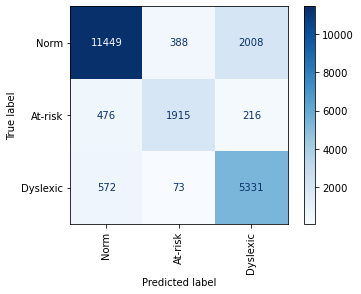

In [103]:


disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)




In [104]:


sklearn.metrics.roc_auc_score(y_test, 
                              mdl.predict_proba(x_test),
                              multi_class="ovr",
                              average="weighted"
                             )




0.9472042144687667

In [120]:

y_pred = mdl.predict(x_test)


In [121]:


sklearn.metrics.adjusted_rand_score(y_test, y_pred)


0.5298600368154661

In [122]:

sklearn.metrics.normalized_mutual_info_score(y_test, y_pred)


0.44878873839023403

In [130]:


sklearn.metrics.precision_score(y_test, 
                                y_pred, 
                                average='weighted')



0.84724249050296

In [132]:


sklearn.metrics.recall_score(y_test, y_pred, average='weighted')



0.8335562689495274

In [133]:

sklearn.metrics.f1_score(y_test, y_pred, average='weighted')



0.835899493786653

In [136]:

sklearn.metrics.accuracy_score(y_test, y_pred)


0.8335562689495274

In [137]:


sklearn.metrics.cohen_kappa_score(y_test, y_pred)



0.6995394534431523

- 




In [105]:


len(list(x_org.columns)) == x_test.shape[1]




True

In [138]:
explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [ ]:


shap_values = explainer(x_test)




Exact explainer:   3%|████▏                                                                                                                   | 774/22428 [04:18<2:05:46,  2.87it/s]

In [ ]:


print("Shap values are determined!")



In [ ]:


y_test.shape, x_test.shape, shap_values.values.shape



- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

In [ ]:
# shap.summary_plot(shap_values, 
#                   x_test, 
#                   plot_type="bar", 
#                   class_names=class_names, 
#                   feature_names=list(x_org.columns),
#                   alpha=0.1,
#                   color_bar=True,
#                   color_bar_label=True
#                  )



### Shap bar plot



In [ ]:

shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")




- The bar plot above depicgts the Mean Absolute SHAP (MAS) values for each feature across the entire data. MAS, on average, quantifies, the magnitude of each feature's contribution towards the predicted class labels. The higher the MAS value for a a feature the more influential that feature is.


- The gender SHAP values sums up to 0.35 turning it two one of the most influentioal features. 
- IQ, Age and the third and fourth grades are the other important features in predicing the class labels.
- Althoght the remaining features have less significant SHAP values, still they all plan a role in predicting class labels.

- More info on beeswarm-bar plot 

In [ ]:
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")



##### Beeswarm-bar plot: 

In addition to observe the same pattern on the relative importannce of features, one can observe that:

- There are quite a few sixth grade participants with very high SHAP values despite of its low MAS value in general.

- 



### SHAP Beeswarm Plots


- Permutation importance numerically measures the importance of features. This simplifies the comparison between features.  However, the considered interaction between features during the features importance determination process, as can be considered a severe drawback of this method. SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 

- The points are distributed horizontally along the x-axis according to their SHAP value. In places where there is a high density of SHAP values, the points are stacked vertically. Examining how the SHAP values are distributed reveals how a variable may influence the model's predictions.

- The colour bar corresponds to the raw values (not to be confused with the SHAP values) of the variables for each instance (i.e. point) on the graph. If the value of a variable for a particular instance is relatively high, it appears as a red dot. Relatively low variable values appear as blue dots. Examining the color distribution horizontally along the x-axis for each variable provides insights into the general relationship between a variable's raw values and its SHAP values.


- These (the columns) are the input variables, ranked from top to bottom by their mean absolute SHAP values for the entire dataset. Note: this ranking is exactly the same as for the bar plot.



In [ ]:
shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




- None-female (male) students have the highest negative SHAP values, implying the significance of this feature on prediction results. 


- Only the two extremes of students' "IQ" have direct impacts models prediction.


- Similar to IQ features, only the two extremes of "Age" feature plays an important role in models prediction.


- Most of the 3rd and 4th grade students, unlike the rest of grades, have high SHAP values which demostrates the importance of these two features.


- Fixation along Y-axis is more important than X-axis. 


- The 6th grade has no low impact on model's prediction result. 





### SHAP Dependence Contribution Plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.


- Each dot is a single prediction (row) from the dataset.
- The x-axis is the actual value from the dataset.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.

In [ ]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")


- The vertical spread of SHAP values at a fixed raw variable value is due to interaction effects with other variables. For example, here we see that sex_1 equal to unity (female) can have SHAP values that range from $-0.6 to 0.15$ depending on the other data for those particular instances. 


- The shapes of the distributions of points provide insights into the relationship between a variable's values and its SHAP values. We cannot see any specific relation between any individual feature and its importance (its SHAP values).



In [ ]:
# n = 5
# fig, ax = plt.subplots(1, n, figsize=(15, 5))

# for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
#     if i < n:
#         shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
#         ax[i].grid(axis="y")
#         if i != 0:
#             ax[i].set_ylabel("")
#             ax[i].spines["left"].set_visible(False)
#             ax[i].set_ylim(ax[0].get_ylim())
#             ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
#         else:
#             ax[i].set_ylabel("SHAP value")
# # fig.savefig("plots/scatter_top5.png")

##### Dependece plots:

- 


In [ ]:
for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)



- 


## Individual force plots of 3 randomly selected samples of each class


In [ ]:



normals = np.where(y_test == 1)[0]
at_risks = np.where(y_test == 2)[0]
dyslexics = np.where(y_test == 3)[0]



n_size = 5
np.random.seed(43)
normals_rnd = np.random.choice(normals, n_size)
at_risks_rnd = np.random.choice(at_risks, n_size)
dyslexics_rnd = np.random.choice(dyslexics, n_size)




In [ ]:
normals_rnd



In [ ]:
at_risks_rnd


In [ ]:

dyslexics_rnd


In [ ]:
for n in normals_rnd:
    shap.plots.force(shap_values[n], show=False, matplotlib=True)
    
    

In [ ]:
for r in at_risks_rnd:
    shap.plots.force(shap_values[r], show=False, matplotlib=True)
    
    

In [ ]:
for d in dyslexics_rnd:
    shap.plots.force(shap_values[d], show=False, matplotlib=True)
    
    